#청와대 청원 : 청원의 주제가 무엇일까?  
##텍스트 데이터를 분석하여 청원 주제 분류하기

##Accuracy: 0.34


##전처리;
###정규표현식
###stemming(okt)/불용어 제거하기
###카운터 기반 임베딩/워드 임베딩


##모델링;
###RNN(drop_out=0.5)
###loss : CrossEntropyLoss, optimizer : Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/22-1 DL 과제/data/청와대 청원.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/22-1 DL 과제/data/청와대 청원.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


##라이브러리 import/기본 설정/하이퍼파라미터 설정

In [ ]:
import os
import torch 
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import random

import pandas as pd
import re

In [ ]:
import pandas as pd
import numpy as np
np.random.seed(456)
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

print(device)

cuda


In [ ]:
# 하이퍼파라미터
batch_size = 64
lr = 0.001
epochs = 50

##데이터 불러오기

In [ ]:
train = pd.read_csv('train.csv', encoding = 'utf-8').iloc[:,1:].dropna(how='any') #한글의 경우 encoding으로 utf-8, ms949,cp949
test = pd.read_csv('test.csv', encoding = 'utf-8').iloc[:, 1:]
sample_submission = pd.read_csv('sample_submission.csv', encoding = 'utf-8')

In [ ]:
train

,category,data
0,2,신혼부부위한 주택정책 보다 보육시설 늘려주세요.. 국민세금으로 일부를 위한 정책펴지...
1,0,학교이름에 '남자'도 붙여주세요. 울산여자중학교에 재학중인 학생입니다 최근 양성평등...
2,1,"빙상연맹, 대한축구협회등 각종 체육협회의 비리를 철저하게 밝혀주세요.. 최근 동계올..."
3,1,"티비 12세,15세 관람가도 연령확인 의무화 하자.. 제기 에전에 티비를 보다가 잠..."
4,1,무더운 여름철엔 남성들도 시원한 자율복장을 해야. 무더운 여름철에는 남성들도 노넥타...
...,...,...
39995,2,시간유연근무제. 저는 국립대에서 일하고 있는 비정규직 근로자입니다.\n동시에 두 ...
39996,0,소년법을 폐지해 주시고 부산 여중생 가해자 학생들의 강력한 처벌을 요구합니다. 소년...
39997,2,무서운데 지켜야 할게 있어요 도와주세요. 안녕하세요 . 한부모엄마 입니다.\n양육비...
39998,2,교복에 고정식 이름표를 달게 하는 것을 금지해 주세요.. 교복에 이름표를 박아놓아...


In [ ]:
train.iloc[0,1]

'신혼부부위한 주택정책 보다 보육시설 늘려주세요.. 국민세금으로 일부를 위한 정책펴지 마시고\\n보편적으로 모든국민이 수긍할  수 있는 복지정책 펴 주시길 바랍니다.\\n저도 신혼부부이지만 당첨되는 사람 로또되는 이런주택정책 반대합니다.\\n국민세금을 일부 사람들에게 퍼주기식이 되면 안되죠..\\n그 세금으로 우리아이 안전하게 맡길 수 있는 보육시설을 전국에 설치해 주세요..\\n대기업들은 솔선수범해서 모든 사업장에 의무설치 할 수 있도록 하시구요..\\n집 보다 애 맡길데가 없어 경력단절 되는게 더 괴롭습니다.!\\n집은 개인의 능력을 키워 사는게 맞습니다.\\n그 능력을 키울수 있도록 육아 전담에 힘을 기울이는게 맞습니다.\\n우리아이 부모가 키우는거 맞지만 이제는 국가가\\n책임지는 시대로 가는게 맞다고 봅니다.\\n그렇잖아도 부동산 가격 자꾸 올라가는게 정부정책이 잘못 되었다고 봅니다.\\n부동산은 그냥 내버려 두세요!  좀!\\n건들수록 역효과네요..'

In [ ]:
print(train.shape)
print(test.shape)
print(sample_submission.shape)

(39992, 2)
(5000, 1)
(5000, 2)


In [ ]:
train['category'].value_counts() #3개의 category

2    13358
1    13335
0    13299
Name: category, dtype: int64

###라벨 종류
0 : 인권/성평등  
1 : 문화/예술/체육/언론  
2 : 육아/교육

#전처리

##정규표현식  
원하는 조건으로 문장 수정하기

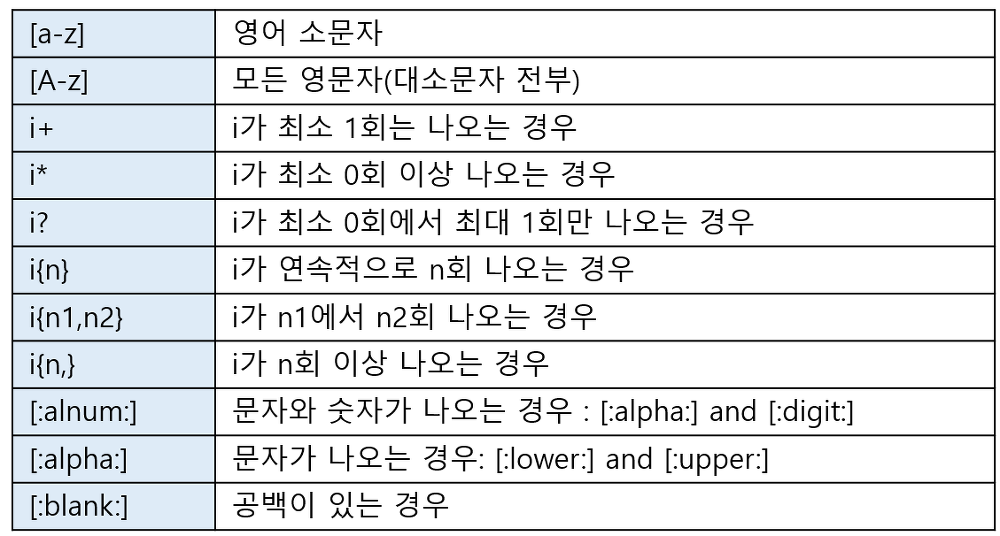

In [ ]:
#부호를 제거해주는 함수
def alpha_num(text):
    return re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', text)

In [ ]:
train['data']=train['data'].apply(alpha_num)
test['data']=test['data'].apply(alpha_num)

In [ ]:
train.iloc[0,1]

'신혼부부위한 주택정책 보다 보육시설 늘려주세요 국민세금으로 일부를 위한 정책펴지 마시고보편적으로 모든국민이 수긍할  수 있는 복지정책 펴 주시길 바랍니다저도 신혼부부이지만 당첨되는 사람 로또되는 이런주택정책 반대합니다국민세금을 일부 사람들에게 퍼주기식이 되면 안되죠그 세금으로 우리아이 안전하게 맡길 수 있는 보육시설을 전국에 설치해 주세요대기업들은 솔선수범해서 모든 사업장에 의무설치 할 수 있도록 하시구요집 보다 애 맡길데가 없어 경력단절 되는게 더 괴롭습니다집은 개인의 능력을 키워 사는게 맞습니다그 능력을 키울수 있도록 육아 전담에 힘을 기울이는게 맞습니다우리아이 부모가 키우는거 맞지만 이제는 국가가책임지는 시대로 가는게 맞다고 봅니다그렇잖아도 부동산 가격 자꾸 올라가는게 정부정책이 잘못 되었다고 봅니다부동산은 그냥 내버려 두세요  좀건들수록 역효과네요'

##stemming/불용어 제거하기

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 4.0 MB/s 
     |████████████████████████████████| 448 kB 65.8 MB/s 


In [ ]:
from konlpy.tag import Okt

In [ ]:
okt = Okt()

**Okt(Open Korean Text)**는 트위터에서 만든 오픈소스 한국어 처리기인 twitter-korean-text를 이어받아 만들고 있는 프로젝트

출처: https://needjarvis.tistory.com/645 [자비스가 필요해]

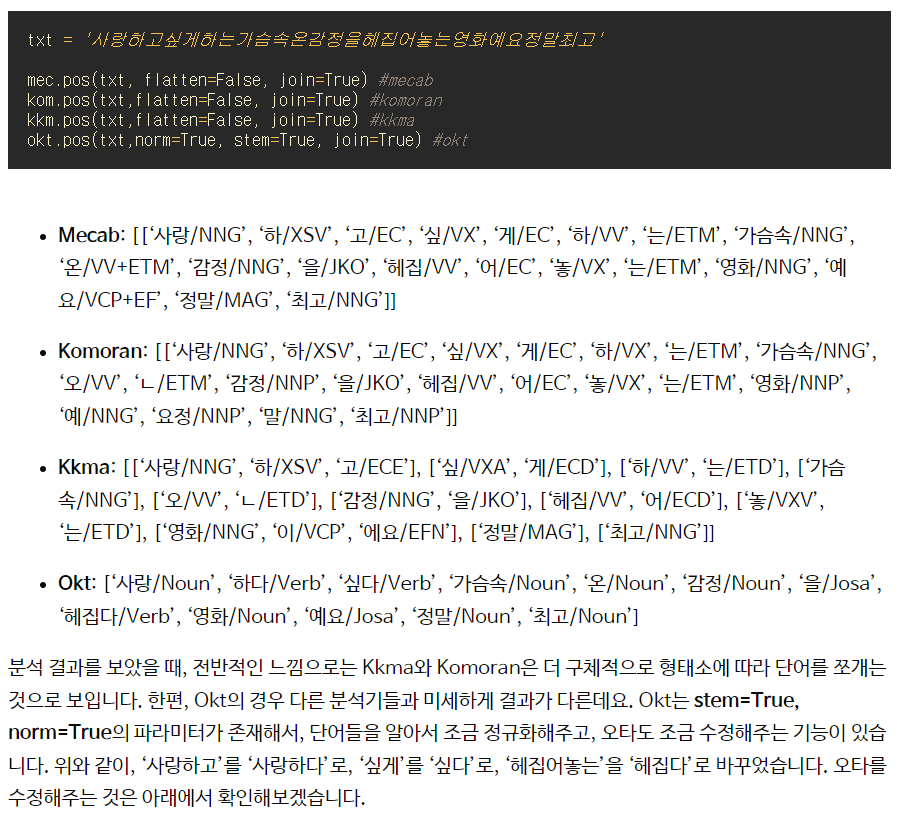

[출처] https://soohee410.github.io/compare_tagger

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을']

In [ ]:
def remove_stopwords(text):
    final_text = []
    words = okt.morphs(text, stem=True)
    for word in words:
        if word.strip().lower() not in stopwords:
          final_text.append(word.strip())
    return  " ".join(final_text)

In [ ]:
train['data'] = train['data'].apply(remove_stopwords)
test['data'] = test['data'].apply(remove_stopwords)

In [ ]:
train

,category,data
0,2,신혼부부 위 주택 정책 보다 보육 시설 늘리다 국민 세금 일부 위 정책 펴다 말다 ...
1,0,학교 이름 남자 붙이다 울산 여자 중학교 재학 중 인 학생 이다 최근 양성평등 글짓...
2,1,빙상 연맹 대 축구 협회 등 각종 체육 협회 비리 철저하다 밝히다 최근 동계올림픽 ...
3,1,티비 세다 관람 가도 연령 확인 의무 화 하자 제기 에전 티비 보다 잠시 딴 일이 ...
4,1,무덥다 여름철 엔 남성 시원하다 자율 복장 무덥다 여름철 에는 남성 노 넥타이 반바...
...,...,...
39995,2,시간 유연근무제 저 국립대 에서 일 하고 있다 비정규직 근로자 이다 동시 두 자녀 ...
39996,0,소년법 폐지 주시 고 부산 여중생 가해자 학생 강력하다 처벌 요구 소년법 폐지 주시...
39997,2,무섭다 지키다 있다 도와주다 안녕하다 한부모 엄마 이다 양육비 받다 싶다 양육비 안...
39998,2,교복 고정식 이름 표 달 게 것 금지 줄다 교복 이름 표 박다 탈 부착 수 없다 해...


In [ ]:
test

,data
0,소년법 폐지 해주다 법 아래 에서 보호 받다 아이 이법 인하다 보호 받다 못 하고 ...
1,국 공립 유치원 증설 관 국 공립 유치원 부지 학보 건립 및 증설 지역 어린이 놀이...
2,나경원 파면 나경원 의원 동계올림픽 위원 파면 줄다
3,국민 위원 에가 삼 성 편 만들다 삼성 에서 년 간 일 하고 혈암 백혈병 진단 받다...
4,방과후 유치원 어린이집 영어 교육 유지 시키다 저 아이 셋 키우다 평범하다 주부 이...
...,...
4995,페이스북 개인 신상 정보 개 털리다 이대로 존경 문재인 대통령 님 얼마 전 미국 본...
4996,아시안 게임 야구 프로스포츠 선수 참여 금지 청원 뭐 대놓고 병역 브로커 합법 이라...
4997,손흥민 국가대표 자격 영 구 박탈 청원 광고 찍 때 랑 군 면제 걸리다 때 소속 팀...
4998,한진 사모님 이명희 구속 시키다 방안 찿 아 보다 일단 밝혀지다 피해자 명 이다 아...


##4-1 카운터 기반 임베딩

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

v = TfidfVectorizer(max_features = 400) # max_features를 통해 최대 몇 개의 단어를 벡터로 바꿀 것인지 결정
v.fit(train['data'])

TfidfVectorizer(max_features=400)

In [ ]:
print(v.vocabulary_) # 벡터화된 단어들 사전

{'정책': 319, '보다': 157, '보육': 159, '국민': 40, '세금': 195, '일부': 294, '말다': 125, '모든': 130, '있다': 299, '주다': 328, '바라다': 142, '되다': 104, '사람': 174, '이런': 272, '반대': 145, '에게': 235, '안되다': 218, '우리': 253, '아이': 216, '줄다': 332, '의무': 262, '없다': 232, '개인': 15, '키우다': 357, '살다': 180, '맞다': 126, '부모': 164, '이제': 283, '국가': 38, '가다': 1, '그렇다': 50, '정부': 317, '잘못': 308, '되어다': 105, '그냥': 45, '두다': 106, '학교': 372, '남자': 67, '여자': 243, '학생': 375, '이다': 266, '최근': 351, '생각': 183, '하나': 369, '인데': 288, '지다': 336, '모르다': 131, '에도': 237, '해주다': 386, '이르다': 275, '동안': 101, '현실': 389, '바꾸다': 141, '않다': 219, '싶다': 211, '지금': 335, '아니다': 213, '이렇다': 274, '다른': 82, '고등학교': 26, '문제': 136, '해결': 382, '연맹': 244, '축구': 353, '협회': 392, '비리': 171, '에서': 238, '선수': 188, '관련': 31, '크다': 356, '이번': 278, '대해': 96, '많다': 123, '일이': 295, '마다': 118, '시작': 205, '감독': 8, '내다': 69, '정말': 316, '경기': 22, '모습': 132, '보이다': 160, '하고': 368, '올림픽': 249, '계속': 25, '까지': 60, '정도': 315, '분들': 169, '많이': 124, '이야기': 280, '이상': 279, 

In [ ]:
x = v.transform(train['data']).toarray()
print(x)

[[0.         0.06902653 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.12187341 0.         0.         ... 0.         0.         0.        ]
 [0.35850135 0.117599   0.         ... 0.         0.         0.        ]]


In [ ]:
print(x.shape) #문장수, 단어수
print(train.shape)

(39992, 400)
(39992, 2)


In [ ]:
x = pd.DataFrame(x)
temp = []
for i in range(len(x)):
  temp.append(list(x.iloc[i,:]))
train['preprocessed_text'] = temp

In [ ]:
train

,category,data,preprocessed_text
0,2,신혼부부 위 주택 정책 보다 보육 시설 늘리다 국민 세금 일부 위 정책 펴다 말다 ...,"[0.0, 0.06902652576345275, 0.0, 0.0, 0.0, 0.0,..."
1,0,학교 이름 남자 붙이다 울산 여자 중학교 재학 중 인 학생 이다 최근 양성평등 글짓...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,빙상 연맹 대 축구 협회 등 각종 체육 협회 비리 철저하다 밝히다 최근 동계올림픽 ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.538..."
3,1,티비 세다 관람 가도 연령 확인 의무 화 하자 제기 에전 티비 보다 잠시 딴 일이 ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,무덥다 여름철 엔 남성 시원하다 자율 복장 무덥다 여름철 에는 남성 노 넥타이 반바...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
39995,2,시간 유연근무제 저 국립대 에서 일 하고 있다 비정규직 근로자 이다 동시 두 자녀 ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
39996,0,소년법 폐지 주시 고 부산 여중생 가해자 학생 강력하다 처벌 요구 소년법 폐지 주시...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.40523050..."
39997,2,무섭다 지키다 있다 도와주다 안녕하다 한부모 엄마 이다 양육비 받다 싶다 양육비 안...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
39998,2,교복 고정식 이름 표 달 게 것 금지 줄다 교복 이름 표 박다 탈 부착 수 없다 해...,"[0.12187341311508817, 0.0, 0.0, 0.0, 0.0, 0.0,..."


##4-2 워드 임베딩

In [ ]:
word_set = []
max_len = 0

for d in train['data']:
  word_set = word_set + d.split(' ') # 여기에 토큰화한 데이터가 들어가면 된다
  if len(d.split()) > max_len:
    max_len = len(d.split())
  
word_set = set(word_set)

In [ ]:
word_to_idx = {word: i+1 for i, word in enumerate(word_set)}
print(len(word_set))
print(max_len)

55137
9394


In [ ]:
def word_to_key(text):
  final_text = []
  for word in text.split():
      final_text.append(word_to_idx[word])
  if len(final_text) < max_len:
    final_text = final_text + [0] * (max_len - len(final_text))
  return final_text


train['word_to_key'] = train['data'].apply(word_to_key)

In [ ]:
train

,category,data,preprocessed_text,word_to_key
0,2,신혼부부 위 주택 정책 보다 보육 시설 늘리다 국민 세금 일부 위 정책 펴다 말다 ...,"[0.0, 0.06902652576345275, 0.0, 0.0, 0.0, 0.0,...","[27765, 41140, 51576, 32675, 5017, 26874, 1865..."
1,0,학교 이름 남자 붙이다 울산 여자 중학교 재학 중 인 학생 이다 최근 양성평등 글짓...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[52682, 14130, 18904, 26249, 1149, 47998, 4341..."
2,1,빙상 연맹 대 축구 협회 등 각종 체육 협회 비리 철저하다 밝히다 최근 동계올림픽 ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.538...","[41484, 14612, 8528, 35121, 44514, 50647, 4564..."
3,1,티비 세다 관람 가도 연령 확인 의무 화 하자 제기 에전 티비 보다 잠시 딴 일이 ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1824, 7452, 35237, 41008, 15407, 2673, 29839,..."
4,1,무덥다 여름철 엔 남성 시원하다 자율 복장 무덥다 여름철 에는 남성 노 넥타이 반바...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[7250, 18674, 37751, 22401, 46380, 34891, 4646..."
...,...,...,...,...
39995,2,시간 유연근무제 저 국립대 에서 일 하고 있다 비정규직 근로자 이다 동시 두 자녀 ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[32127, 23958, 27885, 3216, 7318, 18503, 29954..."
39996,0,소년법 폐지 주시 고 부산 여중생 가해자 학생 강력하다 처벌 요구 소년법 폐지 주시...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.40523050...","[36648, 52627, 41971, 11591, 36191, 42267, 368..."
39997,2,무섭다 지키다 있다 도와주다 안녕하다 한부모 엄마 이다 양육비 받다 싶다 양육비 안...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1522, 9955, 2617, 16717, 36864, 46600, 2647, ..."
39998,2,교복 고정식 이름 표 달 게 것 금지 줄다 교복 이름 표 박다 탈 부착 수 없다 해...,"[0.12187341311508817, 0.0, 0.0, 0.0, 0.0, 0.0,...","[46814, 48873, 14130, 17883, 20940, 21163, 904..."


#모델링

In [ ]:
X_train = train.iloc[:25000, 3].reset_index(drop=True)
X_test = train.iloc[25000:, 3].reset_index(drop=True)

y_train = train.iloc[:25000, 0].reset_index(drop=True)
y_test = train.iloc[25000:,0].reset_index(drop=True)

In [ ]:
X_train

0        [27765, 41140, 51576, 32675, 5017, 26874, 1865...
1        [52682, 14130, 18904, 26249, 1149, 47998, 4341...
2        [41484, 14612, 8528, 35121, 44514, 50647, 4564...
3        [1824, 7452, 35237, 41008, 15407, 2673, 29839,...
4        [7250, 18674, 37751, 22401, 46380, 34891, 4646...
                               ...                        
24995    [30566, 15282, 18834, 42768, 14507, 27195, 464...
24996    [36648, 52627, 15485, 9499, 16843, 6219, 18866...
24997    [21063, 12331, 36513, 47790, 22401, 14089, 123...
24998    [37234, 52467, 20934, 53944, 18575, 21420, 471...
24999    [48024, 44382, 19812, 7700, 31692, 48704, 3114...
Name: word_to_key, Length: 25000, dtype: object

In [ ]:
X_test

0        [25535, 41190, 19241, 21420, 25535, 41190, 192...
1        [50811, 43701, 45564, 41667, 5931, 3291, 46576...
2        [4945, 8249, 2301, 28418, 45308, 19988, 41746,...
3        [42034, 28748, 5410, 54620, 31692, 49426, 1393...
4        [41484, 14612, 3248, 41140, 48654, 6841, 36655...
                               ...                        
14987    [32127, 23958, 27885, 3216, 7318, 18503, 29954...
14988    [36648, 52627, 41971, 11591, 36191, 42267, 368...
14989    [1522, 9955, 2617, 16717, 36864, 46600, 2647, ...
14990    [46814, 48873, 14130, 17883, 20940, 21163, 904...
14991    [31170, 8891, 1610, 42063, 15407, 52955, 2909,...
Name: word_to_key, Length: 14992, dtype: object

In [ ]:
class CustomDataset(Dataset):
  def __init__(self):
    
    self.x_data = X_train
    self.y_data = [[y] for y in y_train]

  def __len__(self):

    return len(self.x_data)

  def __getitem__(self, idx):

    x = torch.LongTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)

    return x,y

In [ ]:
class CustomDataset_test(Dataset):
  def __init__(self):
    
    self.x_data = X_test
    self.y_data = [[y] for y in y_test]

  def __len__(self):

    return len(self.x_data)

  def __getitem__(self, idx):

    x = torch.LongTensor(self.x_data[idx])
    y = torch.LongTensor(self.y_data[idx])

    return x,y

In [ ]:
dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size) 

In [ ]:
# 여기서 혹시 gru를 써보고 싶다면 주석을 풀고 시행하면 됩니다. 

class RNN(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
      super(RNN, self).__init__()
      self.n_layers = n_layers
      self.hidden_dim = hidden_dim

      self.embed = nn.Embedding(n_vocab, embed_dim)
      self.dropout = nn.Dropout(dropout_p)
      # self.gru = nn.GRU(embed_dim, self.hidden_dim,
      #                  num_layers=self.n_layers,
      #                  batch_first=True)
      self.rnn = nn.RNN(embed_dim, self.hidden_dim,batch_first = True)
      self.out = nn.Sequential(
          nn.Linear(self.hidden_dim, n_classes),
          nn.Softmax()
      )
    def forward(self, x):
      x = self.embed(x)
      h_0 = self._init_state(batch_size=x.size(0)) # 첫번째 히든 스테이트를 0벡터로 초기화
      #x, _ = self.gru(x, h_0)  # GRU의 리턴값은 (배치 크기, 시퀀스 길이, 은닉 상태의 크기)
      x, _ = self.rnn(x,h_0)
      h_t = x[:,-1,:] # (배치 크기, 은닉 상태의 크기)의 텐서로 크기가 변경됨. 즉, 마지막 time-step의 은닉 상태만 가져온다.
      self.dropout(h_t)
      logit = self.out(h_t)  # (배치 크기, 은닉 상태의 크기) -> (배치 크기, 출력층의 크기)
      return logit

    def _init_state(self, batch_size=1):
      weight = next(self.parameters()).data
      return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

In [ ]:
n_vocab = 55137+1
embedd_size = 8
hidden_size = 128
output_size = 3

In [ ]:
net = RNN(1, 256, n_vocab, embedd_size, output_size, 0.5).to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr)

In [ ]:
losses = []
for epoch in range(epochs):
  
  for x, y in dataloader:
    optimizer.zero_grad()
    y = y.to(device)

    # forward 연산
    hypothesis = net(x)

    # 비용 함수
    y = y.squeeze()
    cost = criterion(hypothesis, y)
    cost.backward()
    optimizer.step()
    losses.append(cost.item()) # 값만 가져오기 위해서 .item()

  # 10의 배수에 해당되는 에포크마다 비용을 출력
  if epoch % 10 == 0:
      print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.093640685081482
10 1.0950945615768433
20 1.104780912399292
30 1.0784412622451782
40 1.0759844779968262


In [ ]:
dataset = CustomDataset_test()
test_loader = DataLoader(dataset, batch_size=batch_size)

In [ ]:
correct = 0

with torch.no_grad():
  net = net.to('cpu')
  net.eval()
  for data, target in test_loader:
    data, target = data, target
    output = net(data)
    
    pred = output.max(1, keepdim=True)[1]
    # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
    correct += pred.eq(target.view_as(pred)).sum().item()

test_accuracy = correct / len(test_loader.dataset)
print('Accuracy:', test_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy: 0.3401147278548559


In [ ]:
pred

tensor([[2],
        [2],
        [2],
        [0],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [0],
        [2],
        [0]])

In [ ]:
output

tensor([[0.3106, 0.3233, 0.3661],
        [0.2279, 0.3469, 0.4252],
        [0.1082, 0.3813, 0.5105],
        [0.4393, 0.3362, 0.2244],
        [0.2279, 0.3469, 0.4252],
        [0.3106, 0.3233, 0.3661],
        [0.3106, 0.3233, 0.3661],
        [0.1082, 0.3813, 0.5105],
        [0.3106, 0.3233, 0.3661],
        [0.2279, 0.3469, 0.4252],
        [0.3106, 0.3233, 0.3661],
        [0.3106, 0.3233, 0.3661],
        [0.1082, 0.3813, 0.5105],
        [0.4393, 0.3362, 0.2244],
        [0.3106, 0.3233, 0.3661],
        [0.5665, 0.2134, 0.2201]])